In [24]:
from collections import OrderedDict
import os

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, accuracy_score
#import shap
#!pip install shap
import shap
from sklearn.manifold import TSNE

from tscv import GapRollForward

In [25]:
df = pd.read_parquet('df_final.parquet').sort_values(by=['data'])
df = df[df.data > '2019-01-01']
df

,id_votacao,id_parlamentar,id_parlamentar_parlametria,voto,casa_x,id_proposicao,data,obj_votacao,casa_y,is_nominal,...,partido_PTB,partido_PTC,partido_PTN,partido_PTdoB,partido_PV,partido_REDE,partido_REPUBLICANOS,partido_S.PART.,partido_SD,partido_SOLIDARIEDADE
224037,2179189-45,204571,1204571,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,True,...,0,0,0,0,0,0,0,0,0,0
70819,2179189-45,204517,1204517,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,True,...,0,0,0,0,0,0,0,0,0,0
224614,2179189-45,74273,174273,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,True,...,0,0,0,0,0,0,0,0,0,0
156266,2179189-45,204352,1204352,0,camara,2179189.0,2019-02-12 16:26:57,0,camara,True,...,0,0,0,0,0,0,0,0,0,0
156857,2179189-45,204531,1204531,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,True,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148877,2272137-269,178835,1178835,0,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,True,...,0,0,0,0,0,0,0,0,0,0
69095,2272137-269,198197,1198197,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,True,...,0,0,0,0,0,0,0,0,0,0
248742,2272137-269,141553,1141553,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,True,...,0,0,0,0,0,0,0,0,0,0
86439,2272137-269,160531,1160531,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,True,...,0,0,0,0,0,0,1,0,0,0


In [5]:
themes = [feature for feature in df.columns if feature.startswith('tema_')]
#date = ['ano','mes']
keyw = [feature for feature in df.columns if feature.startswith('keyw_')]
acoes = [feature for feature in df.columns if feature.startswith('acoes_')]
at_twitter = [feature for feature in df.columns if feature.startswith('atividade_twitter')]
autorias = [feature for feature in df.columns if feature.startswith('aut_')]
disc = [feature for feature in df.columns if feature.startswith('dis_')]
peso = [feature for feature in df.columns if feature.startswith('peso_')]
doacoes = [feature for feature in df.columns if feature.startswith('doacoes_')]
# frentes = [feature for feature in df.columns if feature.startswith('front')]
# inv = [feature for feature in df.columns if feature.startswith('investiment')]
partido = [feature for feature in df.columns if feature.startswith('partido_')]
features =  themes + keyw + acoes + at_twitter + autorias + disc + peso + doacoes + partido

In [26]:
features = ['doacoes_OUTRAS ATIVIDADES DE SERVIÇOS_proporcao_doacao', 'doacoes_COMÉRCIO VAREJISTA_proporcao_doacao', 'doacoes_ATIVIDADES JURÍDICAS, DE CONTABILIDADE E DE AUDITORIA_total_recebido_geral', 'peso_numero_de_mandatos', 'peso_indice_comissoes', 'keyw_criterio', 'tema_Política, Partidos e Eleições', 'partido_PT', 'partido_PSB', 'partido_PSOL', 'doacoes_CONSTRUÇÃO_total_por_atividade', 'keyw_pagamento', 'doacoes_VIGILÂNCIA E LOCAÇÃO DE MÃO-DE-OBRA TERCEIRIZADA_total_recebido_geral', 'partido_REPUBLICANOS', 'doacoes_INDÚSTRIA METALÚRGICA_total_recebido_geral', 'keyw_fiscalizacao', 'keyw_inclusao', 'keyw_crime', 'partido_PCdoB', 'tema_Saúde', 'tema_Arte, Cultura e Religião']
target = ['voto']

In [27]:
DEFAULT_LGB_PARAMS = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 150,
    "verbose": -1,
    "min_data_in_leaf": 5,
    "boost_from_average": True,
    "random_state": 1
}

LABEL_COLUMN_NAME = 'label'
N_FOLDS = 5
N_TIMES_CV = 50

def _robust_evaluation(X, y):
    """N_TIMES_CV times 5-fold cross validation with lgb model
    
    Arguments:
        estimator {[type]} -- [description]
        X {[type]} -- [description]
        y {[type]} -- [description]
    """
    aucs = []
    for seed in range(N_TIMES_CV):
        eval_hist = lgb.cv(DEFAULT_LGB_PARAMS, lgb.Dataset(X, label=y), nfold=N_FOLDS, seed=seed)
        aucs.append(np.mean(eval_hist['auc-mean']))

    score = np.mean(aucs) 

    return score, aucs

def eval_features(df, features, target, random_state):
    """
    5-fold cross validation with LGBMClassifier
    Used to collect results for SHAP analysis
    """
    stats = OrderedDict()
    
    X = df[features].values
    y = df[target].values.ravel()

    a = [] #array to store AUCs values for each fold
    b = [] #array to store PPVs values for each fold
    # cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)
    cv = GapRollForward(min_train_size=int(300000/5), gap_size=int(300000/10), max_test_size=int(300000/5))
    max_auc = 0
    iter_max_auc = 0
    for i, (train, val) in enumerate(cv.split(X, y)):
        classifier = lgb.LGBMClassifier(**DEFAULT_LGB_PARAMS)
        classifier = classifier.fit(X[train], y[train])
        
        probas_ = classifier.predict_proba(X[val])
        auc = roc_auc_score(y[val], probas_[:, 1])
        pred_test = classifier.predict(X[val]) #making predictions for test data
        pred_train = classifier.predict(X[train]) #making predictions for train data
        ppv = precision_score(y[val], pred_test) #PPV is also the precision of the positive class
        a.append(auc)
        b.append(ppv)
        
        if auc > max_auc:
            max_auc = auc
            iter_max_auc = i
        
        
        stats[i] = {}
        stats[i]['model'] = classifier
        stats[i]['auc'] = auc
        stats[i]['X_train'] = X[train]
        stats[i]['y_train'] = y[train]
        stats[i]['y_pred_train'] = pred_train
        stats[i]['X_test'] = X[val]
        stats[i]['y_test'] = y[val]
        stats[i]['y_pred_test'] = pred_test
        
    stats['mean_auc'] = np.mean(a)
    stats['max_auc'] = np.max(a)
    stats['iter_max_auc'] = iter_max_auc
    stats['mean_ppv'] = np.mean(b)
    return stats, classifier


In [28]:
stats, classifier = eval_features(df,features,target,1)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


In [21]:
stats

OrderedDict([(0,
              {'model': LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
                              metric='auc', min_data_in_leaf=5, num_leaves=150,
                              objective='binary', random_state=1, verbose=-1),
               'auc': 0.8000481753833009,
               'X_train': array([[5.78778135e-02, 3.21543408e-03, 0.00000000e+00, ...,
                       0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                      [1.29287129e-02, 1.72382838e-02, 0.00000000e+00, ...,
                       0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                      [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                       0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                      ...,
                      [2.65721667e-02, 1.54520713e-02, 1.63705130e+06, ...,
                       0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                      [2.78941623e-03, 2.78941623e-03, 

In [29]:
# collect data
selected_iter = stats['iter_max_auc']
X = stats[selected_iter]['X_test']
y = stats[selected_iter]['y_test']
y_pred = stats[selected_iter]['y_pred_test']

baseline = accuracy_score(y, np.zeros(len(y)))
acc = accuracy_score(y,y_pred)

# shap explain
model = stats[selected_iter]['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# find misclassfied and correctly classified examples
y_pred = (shap_values[1].sum(1) + explainer.expected_value[1]) > 0
misclassified = y_pred != y
correct_clas = y_pred == y
# find TP, TN, FP and FN examples
tps = [
    True if y_pred[i] == True and y[i] == True else False for i in range(len(y_pred))
]
tns = [
    True if y_pred[i] == False and y[i] == False else False for i in range(len(y_pred))
]
fps = [
    True if y_pred[i] == True and y[i] == False else False for i in range(len(y_pred))
]
fns = [
    True if y_pred[i] == False and y[i] == True else False for i in range(len(y_pred))
]

# feature order
feature_order = list(range(len(features)))
print(f'Mean AUC: {stats["mean_auc"]:.3f}')
print(f'Current fold AUC: {stats[selected_iter]["auc"]:.3f}')
#print(f'Baseline accuracy: {baseline:.3f}')
print(f'Model accuracy: {acc:.3f}')
print('Label distribution on fold:')
print(pd.Series(y).value_counts())
print(f'Number of TPS: {np.array(tps).sum()}')
print(f'Number of TNS: {np.array(tns).sum()}')
print(f'Number of FPS: {np.array(fps).sum()}')
print(f'Number of FNS: {np.array(fns).sum()}')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Mean AUC: 0.855
Current fold AUC: 0.898
Model accuracy: 0.872
Label distribution on fold:
1    25169
0     8336
dtype: int64
Number of TPS: 24299
Number of TNS: 4904
Number of FPS: 3432
Number of FNS: 870


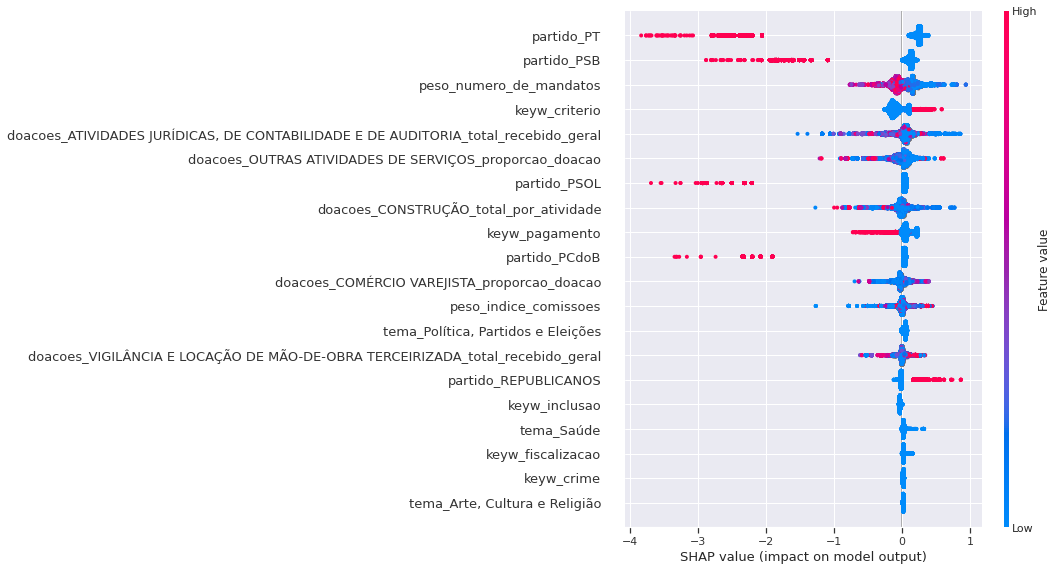

In [23]:
# summary plot (shap values 2-D)
shap.summary_plot(
    shap_values[1],
    X,
    feature_names=features)